In [1]:
import torch.jit
import time
from argparse import ArgumentParser
import numpy as np
import torch

import dlrm.scripts.utils as utils
from dlrm.data.data_loader import get_data_loaders
from dlrm.data.utils import get_categorical_feature_sizes, prefetcher
from dlrm.model.single import Dlrm
from dlrm.utils.checkpointing.serial import SerialCheckpointWriter, make_serial_checkpoint_writer, \
    make_serial_checkpoint_loader

Using the Volta-optimized dot interaction kernels


In [2]:
!cat /data/dlrm/binary_dataset/model_size.json

{
    "_c2": 138493,
    "_c3": 26744
}

In [3]:
import pandas as pd

users_mapping = pd.read_parquet('/mnt/dldata/vinhn/DeepLearningExamples/PyTorch/Recommendation/DLRM/data/dlrm/spark/output/models/2.parquet',engine='pyarrow')

In [4]:
users_mapping.shape

(138493, 3)

In [5]:
users_mapping

,data,id,model_count
0,118205,1,32737
1,8405,2,32255
2,82418,3,31531
3,121535,4,31412
4,125794,5,31368
5,74142,6,31356
6,34576,7,31311
7,131904,8,31299
8,83090,9,31225
9,59477,10,31072


In [6]:
(905-20)*138493 

122566305

In [7]:
5050*26744 

135057200

In [8]:
items_mapping = pd.read_parquet('/mnt/dldata/vinhn/DeepLearningExamples/PyTorch/Recommendation/DLRM/data/dlrm/spark/output/models/3.parquet',engine='pyarrow')

In [31]:
items_mapping.sort_values(by='model_count',  ascending=False)

,data,id,model_count
24464,296,1,73548
24465,356,2,72260
24466,318,3,70512
24467,593,4,69942
24468,480,5,66693
24469,260,6,61927
24470,110,7,61846
24471,589,8,60117
24472,527,9,59153
24473,457,10,59034


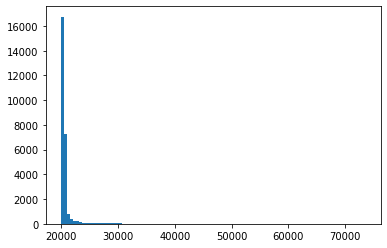

In [10]:
import matplotlib.pyplot as plt
plt.hist(items_mapping['model_count'],100);

In [11]:
np.max(items_mapping['id'])

26744

In [12]:
np.sum(items_mapping['model_count'])

556301394

In [13]:
np.sum(users_mapping['model_count'])

556301394

In [14]:
class flag(object):
    def __init__(self):
        
        # Model configuration
        self.embedding_type = "joint" # The type of the embedding operation to use")
        self.embedding_dim = 128 # "Dimensionality of embedding space for categorical features")
        self.top_mlp_sizes = [1024, 1024, 512, 256, 1] # "Linear layer sizes for the top MLP")
        self.bottom_mlp_sizes = [512, 256, 128] #Linear layer sizes for the bottom MLP")

        self.interaction_op ="cuda_dot" #"Type of interaction operation to perform.")

        self.dataset = "/data/dlrm/binary_dataset/"
        self.dataset_type = "split" #The type of the dataset to use')

        self.base_device = "cuda" #"Device to run the majority of the model operations")
        self.amp = False #If True the script will use Automatic Mixed Precision")
        self.optimized_mlp = True #Use an optimized implementation of MLP from apex")
        self.max_table_size = None #Maximum number of rows per embedding table, by default equal to the number of unique values for each categorical variable")
        self.num_numerical_features = 1
        self.hash_indices = False

In [15]:
FLAGS = flag()

print("Creating model")

model_config = {
    'top_mlp_sizes': FLAGS.top_mlp_sizes,
    'bottom_mlp_sizes': FLAGS.bottom_mlp_sizes,
    'embedding_type': FLAGS.embedding_type,
    'embedding_dim': FLAGS.embedding_dim,
    'interaction_op': FLAGS.interaction_op,
    'categorical_feature_sizes': get_categorical_feature_sizes(FLAGS),
    'num_numerical_features': FLAGS.num_numerical_features,
    'hash_indices': FLAGS.hash_indices,
    'use_cpp_mlp': FLAGS.optimized_mlp,
    'fp16': FLAGS.amp,
    'base_device': FLAGS.base_device,
}

model = Dlrm.from_dict(model_config)
print(model)

Creating model
feature sizes:  [138494, 26745]
Dlrm(
  interaction_op=cuda_dot, hash_indices=False
  (bottom_model): DlrmBottom(
    (embeddings): JointEmbedding(
      offsets=[     0 138494 165239]
      (embedding): Embedding(165239, 128, sparse=True)
    )
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [1, 512, 256, 128], Bias=1, activation=1)
    )
  )
  (top_model): DlrmTop(
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [132, 1024, 1024, 512, 256], Bias=1, activation=1)
    )
    (out): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [16]:
checkpoint_loader = make_serial_checkpoint_loader(
            embedding_indices=range(len(get_categorical_feature_sizes(FLAGS))),
            device="cpu"
        )
checkpoint_loader.load_checkpoint(model, "/workspace/dlrm_vinhn/notebooks/movie_lens_model")
model.eval()
model.to(FLAGS.base_device)

feature sizes:  [138494, 26745]


/workspace/dlrm/dlrm/utils/checkpointing/model.py:128: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(array).to(self._device)


Dlrm(
  interaction_op=cuda_dot, hash_indices=False
  (bottom_model): DlrmBottom(
    (embeddings): JointEmbedding(
      offsets=[     0 138494 165239]
      (embedding): Embedding(165239, 128, sparse=True)
    )
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [1, 512, 256, 128], Bias=1, activation=1)
    )
  )
  (top_model): DlrmTop(
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [132, 1024, 1024, 512, 256], Bias=1, activation=1)
    )
    (out): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [17]:
model.bottom_model.embeddings.embedding.weight.shape

torch.Size([165239, 128])

In [18]:
embedding = model.bottom_model.embeddings.embedding.weight.detach().cpu().numpy()

In [19]:
item_embedding = embedding[138494:]
item_embedding.shape

(26745, 128)

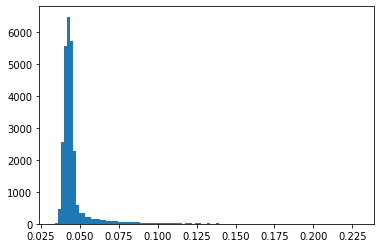

In [20]:
plt.hist(np.linalg.norm(item_embedding, axis=1),100);

In [21]:
from scipy.spatial.distance import cdist
def find_similar_movies(nn_movie_id, item_embedding, k=10, metric='cosine'):
    sim = -cdist(item_embedding, item_embedding[nn_movie_id].reshape(1, -1), metric=metric)
    #sim = np.matmul(item_embedding, item_embedding[nn_movie_id].transpose())
    return sim.squeeze().argsort()[-k:][::-1]

In [22]:
nn_to_movies = {}
movies_to_nn = {}
for _, row in items_mapping.iterrows():
    movies_to_nn[int(row['data'])] = int(row['id'])
    nn_to_movies[int(row['id'])] = int(row['data'])


In [23]:
import pandas as pd
movies = pd.read_csv("/mnt/dldata/vinhn/DeepLearningExamples/PyTorch/Recommendation/NCF/data/ml-20m/movies.csv", index_col="movieId")

movie_ID = 1196 
print("Query: ", movies.loc[movie_ID]["title"], movies.loc[movie_ID]["genres"])

print("Similar movies: ")
similar_movies = find_similar_movies(movies_to_nn[movie_ID], item_embedding)

for i in similar_movies:
    if i==0:
        continue
    print(nn_to_movies[i], movies.loc[nn_to_movies[i]]["title"], movies.loc[nn_to_movies[i]]["genres"])

Query:  Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi
Similar movies: 
1196 Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi
356 Forrest Gump (1994) Comedy|Drama|Romance|War
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
2028 Saving Private Ryan (1998) Action|Drama|War
318 Shawshank Redemption, The (1994) Crime|Drama
590 Dances with Wolves (1990) Adventure|Drama|Western
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi


In [24]:
for movie_ID in range(1000):
    try:
        print("Query: ", movies.loc[movie_ID]["title"], movies.loc[movie_ID]["genres"])

        print("Similar movies: ")
        similar_movies = find_similar_movies(movies_to_nn[movie_ID], item_embedding)

        for i in similar_movies:
            if i==0:
                continue
            print(nn_to_movies[i], movies.loc[nn_to_movies[i]]["title"], movies.loc[nn_to_movies[i]]["genres"])
        print('===============\n')
    except Exception as e:
        print(e)
        pass

0
Query:  Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
Similar movies: 
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
318 Shawshank Redemption, The (1994) Crime|Drama
5952 Lord of the Rings: The Two Towers, The (2002) Adventure|Fantasy
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
457 Fugitive, The (1993) Thriller
356 Forrest Gump (1994) Comedy|Drama|Romance|War

Query:  Jumanji (1995) Adventure|Children|Fantasy
Similar movies: 
2 Jumanji (1995) Adventure|Children|Fantasy
364 Lion King, The (1994) Adventure|Animation|Children|Drama|Musical|IMAX
110 Braveheart (1995) Action|Drama|War
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
356 Forrest Gump (1994) Comedy|Drama|Romance|War
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller


16 Casino (1995) Crime|Drama
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
1221 Godfather: Part II, The (1974) Crime|Drama
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
608 Fargo (1996) Comedy|Crime|Drama|Thriller
231 Dumb & Dumber (Dumb and Dumber) (1994) Adventure|Comedy
110 Braveheart (1995) Action|Drama|War
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
457 Fugitive, The (1993) Thriller

Query:  Sense and Sensibility (1995) Drama|Romance
Similar movies: 
17 Sense and Sensibility (1995) Drama|Romance
32 Twelve Monkeys (a.k.a. 12 Monkeys) (1995) Mystery|Sci-Fi|Thriller
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
597 Pretty Woman (1990) Comedy|Romance
356 Forrest Gump (1994) Comedy|Drama|Romance|War
364 Lion King, The (1994) Adventure|Animation|Children|Drama|Musical|IMAX
1197 Princess Bride, The (1987) Action|Adventure|Comedy|Fanta

Query:  Shanghai Triad (Yao a yao yao dao waipo qiao) (1995) Crime|Drama
Similar movies: 
30 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995) Crime|Drama
3386 JFK (1991) Drama|Mystery|Thriller
4993 Lord of the Rings: The Fellowship of the Ring, The (2001) Adventure|Fantasy
1676 Starship Troopers (1997) Action|Sci-Fi
1393 Jerry Maguire (1996) Drama|Romance
5989 Catch Me If You Can (2002) Crime|Drama
5418 Bourne Identity, The (2002) Action|Mystery|Thriller
2502 Office Space (1999) Comedy|Crime
1923 There's Something About Mary (1998) Comedy|Romance
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller

Query:  Dangerous Minds (1995) Drama
Similar movies: 
31 Dangerous Minds (1995) Drama
47 Seven (a.k.a. Se7en) (1995) Mystery|Thriller
3578 Gladiator (2000) Action|Adventure|Drama
1196 Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi
590 Dances with Wolves (1990) Adventure|Drama|Western
1517 Austin Powers: International Man of Mystery (1997) Action|Adven

45 To Die For (1995) Comedy|Drama|Thriller
2762 Sixth Sense, The (1999) Drama|Horror|Mystery
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
1291 Indiana Jones and the Last Crusade (1989) Action|Adventure
2858 American Beauty (1999) Comedy|Drama
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
377 Speed (1994) Action|Romance|Thriller
457 Fugitive, The (1993) Thriller
858 Godfather, The (1972) Crime|Drama

Query:  How to Make an American Quilt (1995) Drama|Romance
Similar movies: 
46 How to Make an American Quilt (1995) Drama|Romance
377 Speed (1994) Action|Romance|Thriller
6934 Matrix Revolutions, The (2003) Action|Adventure|Sci-Fi|Thriller|IMAX
3996 Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000) Action|Drama|Romance
2396 Shakespeare in Love (1998) Comedy|Drama|Romance
208 Waterworld (1995) Action|Adventure|Sci-Fi
1213 Goodfellas (1990) Crime|Drama
47 Seven (a.k.a. Se7en) (1995) Mystery|Thriller
597 Pretty Woman (1990) Com

7361 Eternal Sunshine of the Spotless Mind (2004) Drama|Romance|Sci-Fi

Query:  Eye for an Eye (1996) Drama|Thriller
Similar movies: 
61 Eye for an Eye (1996) Drama|Thriller
783 Hunchback of Notre Dame, The (1996) Animation|Children|Drama|Musical|Romance
3081 Sleepy Hollow (1999) Fantasy|Horror|Mystery|Romance
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
586 Home Alone (1990) Children|Comedy
110 Braveheart (1995) Action|Drama|War
353 Crow, The (1994) Action|Crime|Fantasy|Thriller
435 Coneheads (1993) Comedy|Sci-Fi
231 Dumb & Dumber (Dumb and Dumber) (1994) Adventure|Comedy
1584 Contact (1997) Drama|Sci-Fi

Query:  Mr. Holland's Opus (1995) Drama
Similar movies: 
62 Mr. Holland's Opus (1995) Drama
1196 Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi
318 Shawshank Redemption, The (1994) Crime|Drama
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
780 Independence Day (a.k.a. ID4) (1996) Ac

Query:  Nico Icon (1995) Documentary
Similar movies: 
77 Nico Icon (1995) Documentary
4951 Lord of the Flies (1990) Adventure|Drama|Thriller
2310 Mighty, The (1998) Drama
3983 You Can Count on Me (2000) Drama|Romance
3992 Malèna (2000) Drama|Romance|War
371 Paper, The (1994) Comedy|Drama
6296 Mighty Wind, A (2003) Comedy|Musical
1284 Big Sleep, The (1946) Crime|Film-Noir|Mystery
49910 Freedom Writers (2007) Drama
7459 Carandiru (2003) Crime|Drama

Query:  Crossing Guard, The (1995) Action|Crime|Drama|Thriller
Similar movies: 
78 Crossing Guard, The (1995) Action|Crime|Drama|Thriller
2003 Gremlins (1984) Comedy|Horror
2985 RoboCop (1987) Action|Crime|Drama|Sci-Fi|Thriller
2997 Being John Malkovich (1999) Comedy|Drama|Fantasy
1221 Godfather: Part II, The (1974) Crime|Drama
1485 Liar Liar (1997) Comedy
1917 Armageddon (1998) Action|Romance|Sci-Fi|Thriller
1200 Aliens (1986) Action|Adventure|Horror|Sci-Fi
3751 Chicken Run (2000) Animation|Children|Comedy
377 Speed (1994) Action|Romance|Thr

Query:  Beautiful Girls (1996) Comedy|Drama|Romance
Similar movies: 
94 Beautiful Girls (1996) Comedy|Drama|Romance
2858 American Beauty (1999) Comedy|Drama
1220 Blues Brothers, The (1980) Action|Comedy|Musical
150 Apollo 13 (1995) Adventure|Drama|IMAX
300 Quiz Show (1994) Drama
2 Jumanji (1995) Adventure|Children|Fantasy
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
1653 Gattaca (1997) Drama|Sci-Fi|Thriller
588 Aladdin (1992) Adventure|Animation|Children|Comedy|Musical
6377 Finding Nemo (2003) Adventure|Animation|Children|Comedy

Query:  Broken Arrow (1996) Action|Adventure|Thriller
Similar movies: 
95 Broken Arrow (1996) Action|Adventure|Thriller
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
2762 Sixth Sense, The (1999) Drama|Horror|Mystery
124

109 Headless Body in Topless Bar (1995) Comedy|Drama|Thriller
60145 Penalty, The (1920) Crime|Drama|Horror
76051 Delhi-6 (2009) Comedy|Crime|Drama
121129 The Hungover Games (2014) Comedy
103557 Tell Me and I Will Forget (2010) Documentary
118862 Closer to the Moon (2013) Comedy|Drama
120452 Get Yourself a College Girl (1964) Comedy
104741 Doctors' Wives (1971) Drama
116419 Drive Hard (2014) Action|Comedy|Crime
122793 Skyjacked (1972) Action|Thriller

Query:  Braveheart (1995) Action|Drama|War
Similar movies: 
110 Braveheart (1995) Action|Drama|War
356 Forrest Gump (1994) Comedy|Drama|Romance|War
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
858 Godfather, The (1972) Crime|Drama
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
780 Independence D

1721 Titanic (1997) Drama|Romance
587 Ghost (1990) Comedy|Drama|Fantasy|Romance|Thriller
588 Aladdin (1992) Adventure|Animation|Children|Comedy|Musical
1617 L.A. Confidential (1997) Crime|Film-Noir|Mystery|Thriller
110 Braveheart (1995) Action|Drama|War
4306 Shrek (2001) Adventure|Animation|Children|Comedy|Fantasy|Romance
1089 Reservoir Dogs (1992) Crime|Mystery|Thriller

Query:  NeverEnding Story III, The (1994) Adventure|Children|Fantasy
Similar movies: 
126 NeverEnding Story III, The (1994) Adventure|Children|Fantasy
1584 Contact (1997) Drama|Sci-Fi
1917 Armageddon (1998) Action|Romance|Sci-Fi|Thriller
163 Desperado (1995) Action|Romance|Western
858 Godfather, The (1972) Crime|Drama
1240 Terminator, The (1984) Action|Sci-Fi|Thriller
1278 Young Frankenstein (1974) Comedy|Fantasy
7153 Lord of the Rings: The Return of the King, The (2003) Action|Adventure|Drama|Fantasy
590 Dances with Wolves (1990) Adventure|Drama|Western
3996 Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000) Act

142 Shadows (Cienie) (1988) Drama
88063 Bugmaster (Mushishi) (2006) Fantasy
8141 Sodom and Gomorrah (1962) Adventure|Drama
102354 About Cherry (2012) Drama
4288 Pola X (1999) Drama|Romance
78991 Slam Dunk Ernest (1995) Children|Comedy
2063 Seventh Heaven (Septième ciel, Le) (1997) Drama|Romance
71575 Rudo y Cursi (Rough and Vulgar) (2008) Comedy|Drama
94271 Voyage to the End of the Universe (Ikarie XB 1) (1963) Sci-Fi
117706 Lost Christmas (2011) Drama

Query:  Gospa (1995) Drama
Similar movies: 
143 Gospa (1995) Drama
54652 1991: The Year Punk Broke (1992) Documentary
31869 Samson and Delilah (1949) Drama|Romance
110267 Season of Monsters (Szörnyek évadja) (1987)  Drama
104423 Snows of Kilimanjaro, The (Neiges du Kilimandjaro, Les) (2011) Drama
32972 Dr. Akagi (Kanzo sensei) (1998) Comedy|Drama|War
79642 Dreamboat (1952) Comedy
119901 Sharpe's Gold (1995) Action|Adventure|War
101583 Best and the Brightest, The (2010) Comedy
116722 Stromberg - Der Film (2014) Comedy

Query:  Brothers M

Similar movies: 
158 Casper (1995) Adventure|Children
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
500 Mrs. Doubtfire (1993) Comedy|Drama
231 Dumb & Dumber (Dumb and Dumber) (1994) Adventure|Comedy
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
457 Fugitive, The (1993) Thriller
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
2858 American Beauty (1999) Comedy|Drama
1210 Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Sci-Fi
1221 Godfather: Part II, The (1974) Crime|Drama

Query:  Clockers (1995) Crime|Drama|Mystery
Similar movies: 
159 Clockers (1995) Crime|Drama|Mystery
4226 Memento (2000) Mystery|Thriller
46578 Little Miss Sunshine (2006) Adventure|Comedy|Drama
2918 Ferris Bueller's Day Off (1986) Comedy
62 Mr. Holland's Opus (1995) Drama
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
2000 Lethal Weapon (1987) Action|Comedy|Crime|Drama
10 GoldenEye (1995) Action|Adventure|Thriller
2797 Big (1988) Comedy|Drama|Fantasy|Romance
1777 Weddi

173 Judge Dredd (1995) Action|Crime|Sci-Fi
377 Speed (1994) Action|Romance|Thriller
648 Mission: Impossible (1996) Action|Adventure|Mystery|Thriller
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
380 True Lies (1994) Action|Adventure|Comedy|Romance|Thriller
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
527 Schindler's List (1993) Drama|War
318 Shawshank Redemption, The (1994) Crime|Drama

Query:  Jury Duty (1995) Comedy
Similar movies: 
174 Jury Duty (1995) Comedy
1036 Die Hard (1988) Action|Crime|Thriller
1246 Dead Poets Society (1989) Drama
780 Independence Day (a.k.a. ID4) (1996) Action|Adventure|Sci-Fi|Thriller
34 Babe (1995) Children|Drama
17 Sense and Sensibility (1995) Drama|Romance
2174 Beetlejuice (1988) Comedy|Fantasy
6539 Pirates of the Caribbean: The Curse of the Black Pearl (2003) Action|Adventure|Comedy|Fantasy
2329 America

3864 Godzilla 2000 (Gojira ni-sen mireniamu) (1999) Action|Adventure|Sci-Fi
3911 Best in Show (2000) Comedy
3104 Midnight Run (1988) Action|Comedy|Crime|Thriller
3785 Scary Movie (2000) Comedy|Horror
1147 When We Were Kings (1996) Documentary
141 Birdcage, The (1996) Comedy
3897 Almost Famous (2000) Drama
86 White Squall (1996) Action|Adventure|Drama

Query:  Safe (1995) Thriller
Similar movies: 
190 Safe (1995) Thriller
7153 Lord of the Rings: The Return of the King, The (2003) Action|Adventure|Drama|Fantasy
277 Miracle on 34th Street (1994) Drama
1097 E.T. the Extra-Terrestrial (1982) Children|Drama|Sci-Fi
1393 Jerry Maguire (1996) Drama|Romance
48385 Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan (2006) Comedy
6874 Kill Bill: Vol. 1 (2003) Action|Crime|Thriller
355 Flintstones, The (1994) Children|Comedy|Fantasy
904 Rear Window (1954) Mystery|Thriller
2712 Eyes Wide Shut (1999) Drama|Mystery|Thriller

Query:  Scarlet Letter, The (1995) Drama|Roma

Query:  Unzipped (1995) Documentary
Similar movies: 
206 Unzipped (1995) Documentary
293 Léon: The Professional (a.k.a. The Professional) (Léon) (1994) Action|Crime|Drama|Thriller
2683 Austin Powers: The Spy Who Shagged Me (1999) Action|Adventure|Comedy
1371 Star Trek: The Motion Picture (1979) Adventure|Sci-Fi
95 Broken Arrow (1996) Action|Adventure|Thriller
648 Mission: Impossible (1996) Action|Adventure|Mystery|Thriller
2021 Dune (1984) Adventure|Sci-Fi
8961 Incredibles, The (2004) Action|Adventure|Animation|Children|Comedy
5378 Star Wars: Episode II - Attack of the Clones (2002) Action|Adventure|Sci-Fi|IMAX
6807 Monty Python's The Meaning of Life (1983) Comedy

Query:  Walk in the Clouds, A (1995) Drama|Romance
Similar movies: 
207 Walk in the Clouds, A (1995) Drama|Romance
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
588 Aladdin (1992) Adventure|Animation|Children|Comedy|Musical
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
608 Fargo (1996) Comedy|Crime|Drama|Thrille

223 Clerks (1994) Comedy
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
1198 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) Action|Adventure
318 Shawshank Redemption, The (1994) Crime|Drama
541 Blade Runner (1982) Action|Sci-Fi|Thriller
780 Independence Day (a.k.a. ID4) (1996) Action|Adventure|Sci-Fi|Thriller
1196 Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
32 Twelve Monkeys (a.k.a. 12 Monkeys) (1995) Mystery|Sci-Fi|Thriller
2762 Sixth Sense, The (1999) Drama|Horror|Mystery

Query:  Don Juan DeMarco (1995) Comedy|Drama|Romance
Similar movies: 
224 Don Juan DeMarco (1995) Comedy|Drama|Romance
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
110 Braveheart (1995) Action|Drama|War
1210 Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Sci-Fi
356 Forrest Gump (1994) Comedy|Drama|Romance|War
377 Speed (1994) Action|Romance|Thriller
318 Shawsha

239 Goofy Movie, A (1995) Animation|Children|Comedy|Romance
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
592 Batman (1989) Action|Crime|Thriller
597 Pretty Woman (1990) Comedy|Romance
1517 Austin Powers: International Man of Mystery (1997) Action|Adventure|Comedy
5445 Minority Report (2002) Action|Crime|Mystery|Sci-Fi|Thriller
858 Godfather, The (1972) Crime|Drama
648 Mission: Impossible (1996) Action|Adventure|Mystery|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
1214 Alien (1979) Horror|Sci-Fi

Query:  Hideaway (1995) Thriller
Similar movies: 
240 Hideaway (1995) Thriller
5110 Super Troopers (2001) Comedy|Crime|Mystery
491 Man Without a Face, The (1993) Drama
466 Hot Shots! Part Deux (1993) Action|Comedy|War
3988 How the Grinch Stole Christmas (a.k.a. The Grinch) (2000) Children|Comedy|Fantasy
3977 Charlie's Angels (2000) Action|Comedy
51662 300 (2007) Action|Fantasy|War|IMAX
8368 Harry Potter and the Prisoner of Azkaban (2004) Adventure|Fantasy|IMAX
2617 Mumm

256 Junior (1994) Comedy|Sci-Fi
858 Godfather, The (1972) Crime|Drama
110 Braveheart (1995) Action|Drama|War
4993 Lord of the Rings: The Fellowship of the Ring, The (2001) Adventure|Fantasy
457 Fugitive, The (1993) Thriller
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
4226 Memento (2000) Mystery|Thriller
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
1721 Titanic (1997) Drama|Romance

Query:  Just Cause (1995) Mystery|Thriller
Similar movies: 
257 Just Cause (1995) Mystery|Thriller
858 Godfather, The (1972) Crime|Drama
110 Braveheart (1995) Action|Drama|War
551 Nightmare Before Christmas, The (1993) Animation|Children|Fantasy|Musical
590 Dances with Wolves (1990) Adventure|Drama|Western
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
21 Get Shorty (1995) Comedy|Crime|Thriller
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
1721 Titanic (1997) Drama|Romance
3114 Toy Story 2 (1999) Adventure|

272 Madness of King George, The (1994) Comedy|Drama
318 Shawshank Redemption, The (1994) Crime|Drama
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
2858 American Beauty (1999) Comedy|Drama
2959 Fight Club (1999) Action|Crime|Drama|Thriller
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
356 Forrest Gump (1994) Comedy|Drama|Romance|War

Query:  Mary Shelley's Frankenstein (Frankenstein) (1994) Drama|Horror|Sci-Fi
Similar movies: 
273 Mary Shelley's Frankenstein (Frankenstein) (1994) Drama|Horror|Sci-Fi
457 Fugitive, The (1993) Thriller
592 Batman (1989) Action|Crime|Thriller
110 Braveheart (1995) Action|Drama|War
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
223 Clerks (1994) Comedy
2858 American Beauty (1999) Comed

Query:  Natural Born Killers (1994) Action|Crime|Thriller
Similar movies: 
288 Natural Born Killers (1994) Action|Crime|Thriller
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
590 Dances with Wolves (1990) Adventure|Drama|Western
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
32 Twelve Monkeys (a.k.a. 12 Monkeys) (1995) Mystery|Sci-Fi|Thriller
1198 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) Action|Adventure
1196 Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi
165 Die Hard: With a Vengeance (1995) Action|Crime|Thriller

Query:  Only You (1994) Comedy|Romance
Similar movies: 
289 Only You (1994) Comedy|Romance
420 Beverly Hills Cop III (1994) Action|Comedy|Crime|Thriller
316 Stargate (1994) Action|Adventure|Sci-Fi
733 Rock, The (1996) Action|Adventure|Thriller
923 Citizen Kane (1941) Drama|M

1221 Godfather: Part II, The (1974) Crime|Drama
500 Mrs. Doubtfire (1993) Comedy|Drama
34 Babe (1995) Children|Drama
1917 Armageddon (1998) Action|Romance|Sci-Fi|Thriller
2628 Star Wars: Episode I - The Phantom Menace (1999) Action|Adventure|Sci-Fi
356 Forrest Gump (1994) Comedy|Drama|Romance|War
2858 American Beauty (1999) Comedy|Drama
208 Waterworld (1995) Action|Adventure|Sci-Fi

Query:  Roommates (1995) Comedy|Drama
Similar movies: 
304 Roommates (1995) Comedy|Drama
2300 Producers, The (1968) Comedy
5502 Signs (2002) Horror|Sci-Fi|Thriller
2359 Waking Ned Devine (a.k.a. Waking Ned) (1998) Comedy
300 Quiz Show (1994) Drama
2321 Pleasantville (1998) Comedy|Drama|Fantasy
5218 Ice Age (2002) Adventure|Animation|Children|Comedy
516 Renaissance Man (1994) Comedy|Drama
2948 From Russia with Love (1963) Action|Adventure|Thriller
2100 Splash (1984) Comedy|Fantasy|Romance

Query:  Ready to Wear (Pret-A-Porter) (1994) Comedy
Similar movies: 
305 Ready to Wear (Pret-A-Porter) (1994) Comedy
122

318 Shawshank Redemption, The (1994) Crime|Drama
539 Sleepless in Seattle (1993) Comedy|Drama|Romance
110 Braveheart (1995) Action|Drama|War
1136 Monty Python and the Holy Grail (1975) Adventure|Comedy|Fantasy

Query:  Suture (1993) Film-Noir|Thriller
Similar movies: 
320 Suture (1993) Film-Noir|Thriller
27317 Audition (Ôdishon) (1999) Drama|Horror|Mystery|Romance|Thriller
84954 Adjustment Bureau, The (2011) Romance|Sci-Fi|Thriller
1445 McHale's Navy (1997) Comedy|War
2605 Entrapment (1999) Crime|Thriller
102903 Now You See Me (2013) Crime|Mystery|Thriller
3190 Supernova (2000) Adventure|Sci-Fi|Thriller
4344 Swordfish (2001) Action|Crime|Drama
56152 Enchanted (2007) Adventure|Animation|Children|Comedy|Fantasy|Musical|Romance
1414 Mother (1996) Comedy

Query:  Strawberry and Chocolate (Fresa y chocolate) (1993) Drama
Similar movies: 
321 Strawberry and Chocolate (Fresa y chocolate) (1993) Drama
5618 Spirited Away (Sen to Chihiro no kamikakushi) (2001) Adventure|Animation|Fantasy
2694 Bi

88744 Rise of the Planet of the Apes (2011) Action|Drama|Sci-Fi|Thriller
4006 Transformers: The Movie (1986) Adventure|Animation|Children|Sci-Fi
88140 Captain America: The First Avenger (2011) Action|Adventure|Sci-Fi|Thriller|War
37741 Capote (2005) Crime|Drama
2412 Rocky V (1990) Action|Drama

Query:  What's Eating Gilbert Grape (1993) Drama
Similar movies: 
337 What's Eating Gilbert Grape (1993) Drama
2858 American Beauty (1999) Comedy|Drama
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
356 Forrest Gump (1994) Comedy|Drama|Romance|War
4306 Shrek (2001) Adventure|Animation|Children|Comedy|Fantasy|Romance
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
2628 Star Wars: Episode I - The Phantom Menace (1999) Action|Adventure|Sci-Fi
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
318 Shawshank Redemption, The (1994) Crime|Drama

Query:  Virtuosity (1995) Action|Sci-Fi|Thriller
Similar movies: 


353 Crow, The (1994) Action|Crime|Fantasy|Thriller
1197 Princess Bride, The (1987) Action|Adventure|Comedy|Fantasy|Romance
780 Independence Day (a.k.a. ID4) (1996) Action|Adventure|Sci-Fi|Thriller
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
110 Braveheart (1995) Action|Drama|War
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
34 Babe (1995) Children|Drama
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller

Query:  Cobb (1994) Drama
Similar movies: 
354 Cobb (1994) Drama
19 Ace Ventura: When Nature Calls (1995) Comedy
3148 Cider House Rules, The (1999) Drama
5445 Minority Report (2002) Action|Crime|Mystery|Sci-Fi|Thriller
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
1200 Aliens (1986) Action|Adventure|Horror|Sci-Fi
1101 Top Gun (1986) Action|Romance
2167 Blade (1998) Action|Horror|Thriller
1722 Tomorrow Never Dies (1997) Action|Adventure

369 Mrs. Parker and the Vicious Circle (1994) Drama
1953 French Connection, The (1971) Action|Crime|Thriller
1441 Benny & Joon (1993) Comedy|Romance
2124 Addams Family, The (1991) Children|Comedy|Fantasy
924 2001: A Space Odyssey (1968) Adventure|Drama|Sci-Fi
3072 Moonstruck (1987) Comedy|Romance
1704 Good Will Hunting (1997) Drama|Romance
2724 Runaway Bride (1999) Comedy|Romance
277 Miracle on 34th Street (1994) Drama
2997 Being John Malkovich (1999) Comedy|Drama|Fantasy

Query:  Naked Gun 33 1/3: The Final Insult (1994) Action|Comedy
Similar movies: 
370 Naked Gun 33 1/3: The Final Insult (1994) Action|Comedy
4993 Lord of the Rings: The Fellowship of the Ring, The (2001) Adventure|Fantasy
318 Shawshank Redemption, The (1994) Crime|Drama
34 Babe (1995) Children|Drama
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
1210 Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Sci-Fi
1197 Princess Bride, The 

Query:  S.F.W. (1994) Drama
Similar movies: 
386 S.F.W. (1994) Drama
2398 Miracle on 34th Street (1947) Comedy|Drama
4498 Dead Pool, The (1988) Action|Crime|Thriller
45720 Devil Wears Prada, The (2006) Comedy|Drama
6157 Daredevil (2003) Action|Crime
7361 Eternal Sunshine of the Spotless Mind (2004) Drama|Romance|Sci-Fi
3477 Empire Records (1995) Comedy|Drama
3510 Frequency (2000) Drama|Thriller
438 Cowboy Way, The (1994) Action|Comedy|Drama
1882 Godzilla (1998) Action|Sci-Fi|Thriller

Query:  Low Down Dirty Shame, A (1994) Action|Comedy
Similar movies: 
387 Low Down Dirty Shame, A (1994) Action|Comedy
381 When a Man Loves a Woman (1994) Drama|Romance
1201 Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) Action|Adventure|Western
3471 Close Encounters of the Third Kind (1977) Adventure|Drama|Sci-Fi
1466 Donnie Brasco (1997) Crime|Drama
2012 Back to the Future Part III (1990) Adventure|Comedy|Sci-Fi|Western
708 Truth About Cats & Dogs, The (1996) Comedy|Romance
89

401 Mirage (1995) Action|Thriller
86244 Easy Money (Snabba Cash) (2010) Action|Thriller
78651 Ashes, The (Popioly) (1965) Drama|War
117920 Burt's Buzz (2014) Documentary
100620 Bruna Surfistinha (2011) Drama
106592 Happy Poet, The (2010) Comedy|Drama|Romance
86725 We Are What We Are (Somos lo que hay) (2010) Drama|Horror
3231 Saphead, The (1920) Comedy
112448 Happy Birthday to a Beautiful Woman (2012) Documentary
116710 Young Man with a Horn (1950) Drama|Musical|Romance

Query:  Open Season (1996) Comedy
Similar movies: 
402 Open Season (1996) Comedy
110380 Nitro Circus: The Movie (2012) Action|Comedy|Documentary
119714 Corner Gas: The Movie (2014) Comedy
113831 Passenger Side (2009) Comedy|Drama
72840 Cover-Up (1991) Action|Thriller
116943 Thesis on a Homicide (2013) Crime|Mystery|Thriller
85143 Adam Had Four Sons (1941) Drama|Romance
83268 Flow (2008) Documentary
78422 How About You... (2007) Comedy|Drama
34234 Pornography (Pornografia) (2003) Drama|Romance|War

Query:  Two Crimes (D

356 Forrest Gump (1994) Comedy|Drama|Romance|War
4306 Shrek (2001) Adventure|Animation|Children|Comedy|Fantasy|Romance

Query:  Being Human (1993) Drama
Similar movies: 
418 Being Human (1993) Drama
6874 Kill Bill: Vol. 1 (2003) Action|Crime|Thriller
1674 Witness (1985) Drama|Romance|Thriller
5013 Gosford Park (2001) Comedy|Drama|Mystery
1305 Paris, Texas (1984) Drama|Romance
3671 Blazing Saddles (1974) Comedy|Western
2125 Ever After: A Cinderella Story (1998) Comedy|Drama|Romance
317 Santa Clause, The (1994) Comedy|Drama|Fantasy
3972 Legend of Drunken Master, The (Jui kuen II) (1994) Action|Comedy
1090 Platoon (1986) Drama|War

Query:  Beverly Hillbillies, The (1993) Comedy
Similar movies: 
419 Beverly Hillbillies, The (1993) Comedy
5445 Minority Report (2002) Action|Crime|Mystery|Sci-Fi|Thriller
5952 Lord of the Rings: The Two Towers, The (2002) Adventure|Fantasy
1193 One Flew Over the Cuckoo's Nest (1975) Drama
7438 Kill Bill: Vol. 2 (2004) Action|Drama|Thriller
1196 Star Wars: Epis

434 Cliffhanger (1993) Action|Adventure|Thriller
592 Batman (1989) Action|Crime|Thriller
110 Braveheart (1995) Action|Drama|War
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
1240 Terminator, The (1984) Action|Sci-Fi|Thriller
1721 Titanic (1997) Drama|Romance
356 Forrest Gump (1994) Comedy|Drama|Romance|War
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
318 Shawshank Redemption, The (1994) Crime|Drama
780 Independence Day (a.k.a. ID4) (1996) Action|Adventure|Sci-Fi|Thriller

Query:  Coneheads (1993) Comedy|Sci-Fi
Similar movies: 
435 Coneheads (1993) Comedy|Sci-Fi
2858 American Beauty (1999) Comedy|Drama
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
648 Mission: Impossible (1996) Action|Adventure|Mystery|Thriller
364 Lion King, The (1994) Adventure|Animation|Children|Drama|Musical|IMAX
318 Shawshank Redemption, The (1994) C

450 With Honors (1994) Comedy|Drama
8360 Shrek 2 (2004) Adventure|Animation|Children|Comedy|Musical|Romance
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
608 Fargo (1996) Comedy|Crime|Drama|Thriller
1994 Poltergeist (1982) Horror|Thriller
1207 To Kill a Mockingbird (1962) Drama
293 Léon: The Professional (a.k.a. The Professional) (Léon) (1994) Action|Crime|Drama|Thriller
367 Mask, The (1994) Action|Comedy|Crime|Fantasy
457 Fugitive, The (1993) Thriller
292 Outbreak (1995) Action|Drama|Sci-Fi|Thriller

Query:  Flesh and Bone (1993) Drama|Mystery|Romance
Similar movies: 
451 Flesh and Bone (1993) Drama|Mystery|Romance
2795 National Lampoon's Vacation (1983) Comedy
307 Three Colors: Blue (Trois couleurs: Bleu) (1993) Drama
342 Muriel's Wedding (1994) Comedy
550 Threesome (1994) Comedy|Romance
852 Tin Cup (1996) Comedy|Drama|Romance
333 Tommy Boy (1995) Comedy
46976 Stranger than Fiction (2006) Comedy|Drama|Fantasy|Romance
230 Dolores Claiborne (1995) Drama|Thriller
2245 Working G

466 Hot Shots! Part Deux (1993) Action|Comedy|War
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
3793 X-Men (2000) Action|Adventure|Sci-Fi
1210 Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Sci-Fi
356 Forrest Gump (1994) Comedy|Drama|Romance|War
292 Outbreak (1995) Action|Drama|Sci-Fi|Thriller
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
2858 American Beauty (1999) Comedy|Drama
2571 Matrix, The (1999) Action|Sci-Fi|Thriller

Query:  Live Nude Girls (1995) Comedy
Similar movies: 
467 Live Nude Girls (1995) Comedy
2321 Pleasantville (1998) Comedy|Drama|Fantasy
6333 X2: X-Men United (2003) Action|Adventure|Sci-Fi|Thriller
2302 My Cousin Vinny (1992) Comedy
912 Casablanca (1942) Drama|Romance
1221 Godfather: Part II, The (1974) Crime|Drama
1148 Wallace & Gromit: The Wrong Trousers (1993) Animation|Children|Comedy|Crime
6539 Pirates of the Caribbean: The Curse of the Black Pearl (20

482 Killing Zoe (1994) Crime|Drama|Thriller
4306 Shrek (2001) Adventure|Animation|Children|Comedy|Fantasy|Romance
2959 Fight Club (1999) Action|Crime|Drama|Thriller
32 Twelve Monkeys (a.k.a. 12 Monkeys) (1995) Mystery|Sci-Fi|Thriller
2353 Enemy of the State (1998) Action|Thriller
786 Eraser (1996) Action|Drama|Thriller
1961 Rain Man (1988) Drama
588 Aladdin (1992) Adventure|Animation|Children|Comedy|Musical
750 Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) Comedy|War
527 Schindler's List (1993) Drama|War

Query:  King of the Hill (1993) Drama
Similar movies: 
483 King of the Hill (1993) Drama
724 Craft, The (1996) Drama|Fantasy|Horror|Thriller
1031 Bedknobs and Broomsticks (1971) Adventure|Children|Musical
3979 Little Nicky (2000) Comedy
1544 Lost World: Jurassic Park, The (1997) Action|Adventure|Sci-Fi|Thriller
3968 Bedazzled (2000) Comedy
2643 Superman IV: The Quest for Peace (1987) Action|Adventure|Sci-Fi
3639 Man with the Golden Gun, The (1974) Action|

356 Forrest Gump (1994) Comedy|Drama|Romance|War
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
733 Rock, The (1996) Action|Adventure|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
2571 Matrix, The (1999) Action|Sci-Fi|Thriller

Query:  Mr. Jones (1993) Drama|Romance
Similar movies: 
498 Mr. Jones (1993) Drama|Romance
1245 Miller's Crossing (1990) Crime|Drama|Film-Noir|Thriller
446 Farewell My Concubine (Ba wang bie ji) (1993) Drama|Romance
7444 13 Going on 30 (2004) Comedy|Fantasy|Romance
3037 Little Big Man (1970) Western
49530 Blood Diamond (2006) Action|Adventure|Crime|Drama|Thriller|War
2423 Christmas Vacation (National Lampoon's Christmas Vacation) (1989) Comedy
46723 Babel (2006) Drama|Thriller
3751 Chicken Run (2000) Animation|Children|Comedy
4069 Wedding Planner, The (2001) Comedy|Romance

Query:  Mr. Wonderful (1993) Comedy|Romance
Similar movies: 
499 Mr. Wonderful (1993) Comedy|Romance
1399 Marvin's Room (1996) Drama
1821 Object o

513 Radioland Murders (1994) Comedy|Mystery|Romance
2528 Logan's Run (1976) Action|Adventure|Sci-Fi
52722 Spider-Man 3 (2007) Action|Adventure|Sci-Fi|Thriller|IMAX
1375 Star Trek III: The Search for Spock (1984) Action|Adventure|Sci-Fi
1378 Young Guns (1988) Action|Comedy|Western
1373 Star Trek V: The Final Frontier (1989) Action|Sci-Fi
5690 Grave of the Fireflies (Hotaru no haka) (1988) Animation|Drama|War
44694 Volver (2006) Comedy|Drama
2723 Mystery Men (1999) Action|Comedy|Fantasy
1394 Raising Arizona (1987) Comedy

Query:  Ref, The (1994) Comedy
Similar movies: 
514 Ref, The (1994) Comedy
36 Dead Man Walking (1995) Crime|Drama
353 Crow, The (1994) Action|Crime|Fantasy|Thriller
34 Babe (1995) Children|Drama
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
288 Natural Born Killers (1994) Action|Crime|Thriller
780 Independence Day (a.k.a. ID4) (1996) Action|Adventure|Sci-Fi|Thriller
150 Apollo 13 (1995) Adventure|Drama|IMAX
2987 Who Framed Roger Rabbit? (1988) Adventure|Animation

6539 Pirates of the Caribbean: The Curse of the Black Pearl (2003) Action|Adventure|Comedy|Fantasy
1221 Godfather: Part II, The (1974) Crime|Drama
4226 Memento (2000) Mystery|Thriller
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
457 Fugitive, The (1993) Thriller
5952 Lord of the Rings: The Two Towers, The (2002) Adventure|Fantasy

Query:  Second Best (1994) Drama
Similar movies: 
530 Second Best (1994) Drama
92477 Yes: 9012 Live (1985) Documentary|Musical
107671 Boy Eating the Bird's Food (To agori troei to fagito tou pouliou) (2012) Drama
82984 Mission to Moscow (1943) Drama|War
104017 3 dev adam (Three Giant Men) (1973)  Action|Adventure|Sci-Fi
117714 Enemies Closer (2013) Action|Thriller
117340 On a marché sur Bangkok (2014) Comedy
111389 Kid Cannabis (2014) Drama
8536 Intended, The (2002) Drama|Thriller
124819 Midnight Crossing (1988) Mystery|Thriller

Query:  Secret Garden, The (1993) Children|Drama
Similar movies: 
531 Secret Garden, The (1993) Children|Drama
1210 St

546 Super Mario Bros. (1993) Action|Adventure|Children|Comedy|Fantasy|Sci-Fi
1291 Indiana Jones and the Last Crusade (1989) Action|Adventure
318 Shawshank Redemption, The (1994) Crime|Drama
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
6539 Pirates of the Caribbean: The Curse of the Black Pearl (2003) Action|Adventure|Comedy|Fantasy
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
2762 Sixth Sense, The (1999) Drama|Horror|Mystery
1682 Truman Show, The (1998) Comedy|Drama|Sci-Fi
1246 Dead Poets Society (1989) Drama
377 Speed (1994) Action|Romance|Thriller

Query:  Surviving the Game (1994) Action|Adventure|Thriller
Similar movies: 
547 Surviving the Game (1994) Action|Adventure|Thriller
1645 Devil's Advocate, The (1997) Drama|Mystery|Thriller
2683 Austin Powers: The Spy Who Shagged Me (1999) Action|Adventure|Comedy
48 Pocahontas (1995) Animation|Children|Drama|Musical|Romance
8665 Bourne Supremacy, The (2004) Action|Crime|Thriller
1252 Chinatown (1974) Crime|Fi

Query:  Germinal (1993) Drama|Romance
Similar movies: 
563 Germinal (1993) Drama|Romance
1350 Omen, The (1976) Horror|Mystery|Thriller
3685 Prizzi's Honor (1985) Comedy|Drama|Romance
4383 Crimson Rivers, The (Rivières pourpres, Les) (2000) Crime|Drama|Mystery|Thriller
1806 Paulie (1998) Adventure|Children|Comedy
4865 From Hell (2001) Crime|Horror|Mystery|Thriller
3125 End of the Affair, The (1999) Drama
2951 Fistful of Dollars, A (Per un pugno di dollari) (1964) Action|Western
2135 Doctor Dolittle (1967) Adventure|Children|Musical
40583 Syriana (2005) Drama|Thriller

Query:  Chasers (1994) Comedy
Similar movies: 
564 Chasers (1994) Comedy
5421 Dangerous Lives of Altar Boys, The (2002) Drama
2605 Entrapment (1999) Crime|Thriller
2730 Barry Lyndon (1975) Drama|Romance|War
2109 Jerk, The (1979) Comedy
453 For Love or Money (1993) Comedy|Romance
3095 Grapes of Wrath, The (1940) Drama
5225 And Your Mother Too (Y tu mamá también) (2001) Drama|Romance
27822 Open Water (2003) Drama|Thriller
49

44892 I Love Your Work (2003) Drama|Mystery

Query:  Princess Caraboo (1994) Drama
Similar movies: 
580 Princess Caraboo (1994) Drama
2302 My Cousin Vinny (1992) Comedy
6942 Love Actually (2003) Comedy|Drama|Romance
8874 Shaun of the Dead (2004) Comedy|Horror
1380 Grease (1978) Comedy|Musical|Romance
3 Grumpier Old Men (1995) Comedy|Romance
3639 Man with the Golden Gun, The (1974) Action|Adventure|Thriller
1479 Saint, The (1997) Action|Romance|Sci-Fi|Thriller
1407 Scream (1996) Comedy|Horror|Mystery|Thriller
3087 Scrooged (1988) Comedy|Fantasy|Romance

Query:  Celluloid Closet, The (1995) Documentary
Similar movies: 
581 Celluloid Closet, The (1995) Documentary
552 Three Musketeers, The (1993) Action|Adventure|Comedy|Romance
193 Showgirls (1995) Drama
1275 Highlander (1986) Action|Adventure|Fantasy
32 Twelve Monkeys (a.k.a. 12 Monkeys) (1995) Mystery|Sci-Fi|Thriller
4011 Snatch (2000) Comedy|Crime|Thriller
904 Rear Window (1954) Mystery|Thriller
4979 Royal Tenenbaums, The (2001) Comedy

595 Beauty and the Beast (1991) Animation|Children|Fantasy|Musical|Romance|IMAX
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
2762 Sixth Sense, The (1999) Drama|Horror|Mystery
1198 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) Action|Adventure
110 Braveheart (1995) Action|Drama|War
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
2858 American Beauty (1999) Comedy|Drama
590 Dances with Wolves (1990) Adventure|Drama|Western

Query:  Pinocchio (1940) Animation|Children|Fantasy|Musical
Similar movies: 
596 Pinocchio (1940) Animation|Children|Fantasy|Musical
318 Shawshank Redemption, The (1994) Crime|Drama
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
590 Dances with Wolves (1990) Adventure|Drama|Western
586 Home Alone (1990

858 Godfather, The (1972) Crime|Drama
342 Muriel's Wedding (1994) Comedy
1411 Hamlet (1996) Crime|Drama|Romance
1203 12 Angry Men (1957) Drama
1220 Blues Brothers, The (1980) Action|Comedy|Musical
1221 Godfather: Part II, The (1974) Crime|Drama
1610 Hunt for Red October, The (1990) Action|Adventure|Thriller
50 Usual Suspects, The (1995) Crime|Mystery|Thriller

Query:  Pallbearer, The (1996) Comedy
Similar movies: 
612 Pallbearer, The (1996) Comedy
1962 Driving Miss Daisy (1989) Drama
8360 Shrek 2 (2004) Adventure|Animation|Children|Comedy|Musical|Romance
2291 Edward Scissorhands (1990) Drama|Fantasy|Romance
56367 Juno (2007) Comedy|Drama|Romance
1704 Good Will Hunting (1997) Drama|Romance
1676 Starship Troopers (1997) Action|Sci-Fi
2005 Goonies, The (1985) Action|Adventure|Children|Comedy|Fantasy
2616 Dick Tracy (1990) Action|Crime
1635 Ice Storm, The (1997) Drama

Query:  Jane Eyre (1996) Drama|Romance
Similar movies: 
613 Jane Eyre (1996) Drama|Romance
805 Time to Kill, A (1996) Dram

628 Primal Fear (1996) Crime|Drama|Mystery|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
110 Braveheart (1995) Action|Drama|War
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
2028 Saving Private Ryan (1998) Action|Drama|War
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
150 Apollo 13 (1995) Adventure|Drama|IMAX
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
2858 American Beauty (1999) Comedy|Drama
1721 Titanic (1997) Drama|Romance

Query:  Rude (1995) Drama
Similar movies: 
629 Rude (1995) Drama
84794 What Is It? (2005) Drama
130478 Kitchen in Paris (2014) Comedy
116453 Hateship Loveship (2013) Drama
100300 Wszystko, co kocham (2009) Comedy|Drama
100570 U.S. Seals (2000) Action|Thriller
90895 Take Out (2004) Drama
94760 Chains (Catene) (1949) Crime|Drama
83809 Russell Peters: Outsourced (2006) Comedy|Documentary
127270 Trojan Eddie (1996) Crime|Drama|Romance

Query:  Carried Away (1996) Drama|Romance
Similar movies: 
630 Carried Away (1996) D

644 Happy Weekend (1996) Comedy
66866 They Wait (2007) Horror|Mystery|Thriller
120134 Doggiewoggiez! Poochiewoochiez! (2012) Comedy
82635 Glue (2006) Drama
129518 Forgive Me (2006) Comedy
49955 Wild Side (2004) Drama
25906 Mr. Skeffington (1944) Drama|Romance
6930 Girlhood (2003) Documentary
78612 Mandingo (1975) Action|Romance
111351 Samaritan Zatoichi (Zatôichi kenka-daiko) (Zatôichi 19) (1968) Action|Adventure|Drama

Query:  Nelly & Monsieur Arnaud (1995) Drama
Similar movies: 
645 Nelly & Monsieur Arnaud (1995) Drama
1096 Sophie's Choice (1982) Drama
1429 First Strike (Police Story 4: First Strike) (Ging chaat goo si 4: Ji gaan daan yam mo) (1996) Action|Adventure|Comedy|Thriller
5008 Witness for the Prosecution (1957) Drama|Mystery|Thriller
1687 Jackal, The (1997) Action|Thriller
953 It's a Wonderful Life (1946) Drama|Fantasy|Romance
1105 Children of the Corn IV: The Gathering (1996) Horror
2794 European Vacation (aka National Lampoon's European Vacation) (1985) Adventure|Comedy|R

661 James and the Giant Peach (1996) Adventure|Animation|Children|Fantasy|Musical
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
2959 Fight Club (1999) Action|Crime|Drama|Thriller
3578 Gladiator (2000) Action|Adventure|Drama
318 Shawshank Redemption, The (1994) Crime|Drama
592 Batman (1989) Action|Crime|Thriller
597 Pretty Woman (1990) Comedy|Romance
1198 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) Action|Adventure
1136 Monty Python and the Holy Grail (1975) Adventure|Comedy|Fantasy
2571 Matrix, The (1999) Action|Sci-Fi|Thriller

Query:  Fear (1996) Thriller
Similar movies: 
662 Fear (1996) Thriller
2890 Three Kings (1999) Action|Adventure|Comedy|Drama|War
377 Speed (1994) Action|Romance|Thriller
4886 Monsters, Inc. (2001) Adventure|Animation|Children|Comedy|Fantasy
6365 Matrix Reloaded, The (2003) Action|Adventure|Sci-Fi|Thriller|IMAX
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
1391 Mars Attacks! (1996) Action|Comedy|Sc

679 Run of the Country, The (1995) Drama
5280 Salmonberries (1991) Drama
85360 Cthulhu (2007) Drama|Thriller
6237 Glenn Miller Story, The (1953) Drama
60289 Kit Kittredge: An American Girl (2008) Children|Comedy|Drama|Mystery
52666 Benny's Video (1992) Drama|Horror
5046 Impostor (2002) Action|Drama|Sci-Fi|Thriller
27369 Daria: Is It Fall Yet? (2000) Animation|Comedy
5640 Godzilla, King of the Monsters! (Kaijû-ô Gojira) (1956) Horror|Sci-Fi
6315 Wildcats (1986) Comedy

Query:  Alphaville (Alphaville, une étrange aventure de Lemmy Caution) (1965) Drama|Mystery|Romance|Sci-Fi|Thriller
Similar movies: 
680 Alphaville (Alphaville, une étrange aventure de Lemmy Caution) (1965) Drama|Mystery|Romance|Sci-Fi|Thriller
3263 White Men Can't Jump (1992) Comedy|Drama
1408 Last of the Mohicans, The (1992) Action|Romance|War|Western
1287 Ben-Hur (1959) Action|Adventure|Drama
597 Pretty Woman (1990) Comedy|Romance
1641 Full Monty, The (1997) Comedy|Drama
196 Species (1995) Horror|Sci-Fi
49272 Casino Ro

97959 Other Son, The (Fils de l'autre, Le) (2012) Drama
4414 X: The Man with the X-Ray Eyes (1963) Sci-Fi|Thriller
1325 Amityville: A New Generation (1993) Horror
44193 She's the Man (2006) Comedy|Romance
79731 Seven Angry Men (1955) Drama|Western

Query:  Feeling Minnesota (1996) Drama|Romance
Similar movies: 
697 Feeling Minnesota (1996) Drama|Romance
1375 Star Trek III: The Search for Spock (1984) Action|Adventure|Sci-Fi
51255 Hot Fuzz (2007) Action|Comedy|Crime|Mystery
104 Happy Gilmore (1996) Comedy
1278 Young Frankenstein (1974) Comedy|Fantasy
1200 Aliens (1986) Action|Adventure|Horror|Sci-Fi
2067 Doctor Zhivago (1965) Drama|Romance|War
1201 Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) Action|Adventure|Western
4084 Beverly Hills Cop II (1987) Action|Comedy|Crime|Thriller
367 Mask, The (1994) Action|Comedy|Crime|Fantasy

Query:  Delta of Venus (1995) Drama
Similar movies: 
698 Delta of Venus (1995) Drama
3725 American Pop (1981) Animation|Musical
4046 

712 Captives (1994) Crime|Drama|Romance|Thriller
3261 Singles (1992) Comedy|Drama|Romance
2042 D2: The Mighty Ducks (1994) Children|Comedy
3918 Hellbound: Hellraiser II (1988) Horror
100383 Side Effects (2013) Crime|Drama|Mystery|Thriller
3506 North Dallas Forty (1979) Comedy|Drama
89118 Skin I Live In, The (La piel que habito) (2011) Drama
68205 Crank: High Voltage (2009) Action|Comedy|Crime
425 Blue Sky (1994) Drama|Romance
7377 United States of Leland, The (2003) Crime|Drama

Query:  Of Love and Shadows (1994) Drama
Similar movies: 
713 Of Love and Shadows (1994) Drama
27193 Taxi 2 (2000) Action|Comedy
1605 Excess Baggage (1997) Adventure|Romance
6300 Flickering Lights (Blinkende lygter) (2000) Action|Comedy|Crime
3817 Other Side of Sunday, The (Søndagsengler) (1996) Comedy|Drama
6404 White Sheik, The (Sceicco bianco, Lo) (1952) Comedy|Romance
6643 Tokyo Story (Tôkyô monogatari) (1953) Drama
26302 Scarecrow (1973) Drama
103341 World's End, The (2013) Action|Comedy|Sci-Fi
31431 Booge

728 Cold Comfort Farm (1995) Comedy
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
527 Schindler's List (1993) Drama|War
7153 Lord of the Rings: The Return of the King, The (2003) Action|Adventure|Drama|Fantasy
1210 Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Sci-Fi
1704 Good Will Hunting (1997) Drama|Romance
1206 Clockwork Orange, A (1971) Crime|Drama|Sci-Fi|Thriller
1263 Deer Hunter, The (1978) Drama|War
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
47 Seven (a.k.a. Se7en) (1995) Mystery|Thriller

Query:  Institute Benjamenta, or This Dream People Call Human Life (1995) Drama
Similar movies: 
729 Institute Benjamenta, or This Dream People Call Human Life (1995) Drama
31083 Man Trouble (1992) Comedy|Romance
92756 Hearts of the West (1975) Comedy|Western
55603 My Mom's New Boyfriend (2008) Action|Comedy|Romance|Thriller
6391 Snowball Express (1972) Children|Comedy
92234 Red Tails (2012) Action|Adventure|Drama|War
4461 Siegfried & Roy: The Magic 

98373 Step Up Revolution (2012) Musical

Query:  Wallace & Gromit: A Close Shave (1995) Animation|Children|Comedy
Similar movies: 
745 Wallace & Gromit: A Close Shave (1995) Animation|Children|Comedy
588 Aladdin (1992) Adventure|Animation|Children|Comedy|Musical
1210 Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Sci-Fi
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
318 Shawshank Redemption, The (1994) Crime|Drama
110 Braveheart (1995) Action|Drama|War
356 Forrest Gump (1994) Comedy|Drama|Romance|War
587 Ghost (1990) Comedy|Drama|Fantasy|Romance|Thriller
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
1036 Die Hard (1988) Action|Crime|Thriller

Query:  Force of Evil (1948) Film-Noir
Similar movies: 
746 Force of Evil (1948) Film-Noir
3060 Commitments, The (1991) Comedy|Drama|Musical
540 Sliver (1993) Thriller
46723 Babel (2006) Drama|Thriller
2428 Faculty, The (1998) Horror|Sci-Fi
6537 Terminator 3: Rise of the Machines (2003) Action|Adventure|Sci-Fi

1748 Dark City (1998) Adventure|Film-Noir|Sci-Fi|Thriller
2243 Broadcast News (1987) Comedy|Drama|Romance
2391 Simple Plan, A (1998) Crime|Drama|Thriller
1201 Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) Action|Adventure|Western
8874 Shaun of the Dead (2004) Comedy|Horror
1921 Pi (1998) Drama|Sci-Fi|Thriller

Query:  Phantom, The (1996) Action|Adventure
Similar movies: 
761 Phantom, The (1996) Action|Adventure
356 Forrest Gump (1994) Comedy|Drama|Romance|War
2028 Saving Private Ryan (1998) Action|Drama|War
1721 Titanic (1997) Drama|Romance
349 Clear and Present Danger (1994) Action|Crime|Drama|Thriller
377 Speed (1994) Action|Romance|Thriller
231 Dumb & Dumber (Dumb and Dumber) (1994) Adventure|Comedy
1136 Monty Python and the Holy Grail (1975) Adventure|Comedy|Fantasy
357 Four Weddings and a Funeral (1994) Comedy|Romance
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller

Query:  Striptease (1996) Comedy|Crime
Similar movies: 
762 Striptease (1996) Comedy

777 Pharaoh's Army (1995) War
131160 Oscar and the Lady in Pink (2009) Drama
114436 World of Kanako, The (Kawaki.) (2014) Crime|Drama|Mystery
27268 Bruiser (2000) Horror|Thriller
96522 Zero Years, The (2005) Drama
78071 Panama Hattie (1942) Comedy|Musical
37967 American Yakuza (1993) Action|Drama|Thriller
130351 The Wrecking Crew (2008) Documentary
86502 Flow: For Love of Water (2008) Documentary
108330 Zero Tolerance (Noll tolerans) (1999) Action|Crime|Thriller

Query:  Trainspotting (1996) Comedy|Crime|Drama
Similar movies: 
778 Trainspotting (1996) Comedy|Crime|Drama
318 Shawshank Redemption, The (1994) Crime|Drama
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
2762 Sixth Sense, The (1999) Drama|Horror|Mystery
1206 Clockwork Orange, A (1971) Crime|Drama|Sci-Fi|Thriller
1210 Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Sci-Fi
2858 American Beauty (1999) Comedy|Drama
3578 Gladiator 

793 My Life and Times With Antonin Artaud (En compagnie d'Antonin Artaud) (1993) Drama
95201 To Rome with Love (2012) Comedy
105355 Blue Is the Warmest Color (La vie d'Adèle) (2013) Drama|Romance
4330 Scarlet Empress, The (1934) Drama
26317 Emmanuelle (1974) Drama|Romance
4130 Maid to Order (1987) Comedy|Fantasy
2507 Breakfast of Champions (1999) Comedy|Sci-Fi
1986 Halloween 5: The Revenge of Michael Myers (1989) Horror
6811 PCU (1994) Comedy
2636 Mummy's Ghost, The (1944) Horror

Query:  Midnight Dancers (Sibak) (1994) Comedy|Drama
Similar movies: 
794 Midnight Dancers (Sibak) (1994) Comedy|Drama
26471 Eddie Murphy Delirious (1983) Comedy|Documentary
975 Something to Sing About (1937) Comedy|Musical
27073 Two Hands (1999) Comedy|Crime|Thriller
3474 Retroactive (1997) Sci-Fi|Thriller
74452 Wolfman, The (2010) Horror|Thriller
4324 Kentuckian, The (1955) Drama|Western
6805 Crying Freeman (1995) Action|Crime|Thriller
73929 Legion (2010) Action|Fantasy|Horror|Thriller
8341 Oliver Twist (19

809 Fled (1996) Action|Adventure
2081 Little Mermaid, The (1989) Animation|Children|Comedy|Musical|Romance
33004 Hitchhiker's Guide to the Galaxy, The (2005) Adventure|Comedy|Sci-Fi
2723 Mystery Men (1999) Action|Comedy|Fantasy
4226 Memento (2000) Mystery|Thriller
1127 Abyss, The (1989) Action|Adventure|Sci-Fi|Thriller
1345 Carrie (1976) Drama|Fantasy|Horror|Thriller
2294 Antz (1998) Adventure|Animation|Children|Comedy|Fantasy
15 Cutthroat Island (1995) Action|Adventure|Romance
475 In the Name of the Father (1993) Drama

Query:  Kazaam (1996) Children|Comedy|Fantasy
Similar movies: 
810 Kazaam (1996) Children|Comedy|Fantasy
3418 Thelma & Louise (1991) Adventure|Crime|Drama
2762 Sixth Sense, The (1999) Drama|Horror|Mystery
6365 Matrix Reloaded, The (2003) Action|Adventure|Sci-Fi|Thriller|IMAX
36 Dead Man Walking (1995) Crime|Drama
62 Mr. Holland's Opus (1995) Drama
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
318 Shawshank Redemption, The (1994) Crime|Drama
1089 Reservoir 

827 Convent, The (O Convento) (1995) Drama
45668 Lake House, The (2006) Drama|Fantasy|Romance
42725 Grandma's Boy (2006) Comedy
69275 Dead Snow (Død snø) (2009) Action|Adventure|Comedy|Horror
54426 12:08 East of Bucharest (A fost sau n-a fost?) (2006) Comedy|Drama
100108 Parker (2013) Crime|Thriller
73017 Sherlock Holmes (2009) Action|Crime|Mystery|Thriller
2971 All That Jazz (1979) Drama|Fantasy|Musical
68959 Fullmetal Alchemist the Movie: Conqueror of Shamballa (Gekijô-ban hagane no renkinjutsushi: Shanbara wo yuku mono) (2005) Action|Adventure|Animation|Drama
8814 Without a Paddle (2004) Comedy

Query:  Adventures of Pinocchio, The (1996) Adventure|Children
Similar movies: 
828 Adventures of Pinocchio, The (1996) Adventure|Children
3424 Do the Right Thing (1989) Drama
368 Maverick (1994) Adventure|Comedy|Western
1573 Face/Off (1997) Action|Crime|Drama|Thriller
3052 Dogma (1999) Adventure|Comedy|Fantasy
370 Naked Gun 33 1/3: The Final Insult (1994) Action|Comedy
485 Last Action Hero 

843 Lotto Land (1995) Drama
40559 Highball (1997) Comedy|Drama
26849 Stand, The (1994) Adventure|Drama|Fantasy|Horror|Sci-Fi
8485 Samsara (2001) Adventure|Drama|Romance
60522 Machine Girl, The (Kataude mashin gâru) (2008) Action|Comedy|Fantasy|Horror|Thriller
7136 Stolen Kisses (Baisers volés) (1968) Comedy|Drama|Romance
67925 City Girl (1930) Drama|Romance
5328 Rain (2001) Drama|Romance
73504 Duchess of Langeais, The (a.k.a. Don't Touch the Axe) (Ne touchez pas la hache) (2007) Drama|Romance
128239 The Adventures of Hercules (1985) Comedy|Fantasy

Query:  Story of Xinghua, The (Xinghua san yue tian) (1994) Drama
Similar movies: 
844 Story of Xinghua, The (Xinghua san yue tian) (1994) Drama
2561 True Crime (1999) Crime|Thriller
35347 Animal Farm (1954) Animation|Drama
43836 Pink Panther, The (2006) Adventure|Comedy|Crime
4278 Triumph of the Will (Triumph des Willens) (1934) Documentary
2453 Boy Who Could Fly, The (1986) Drama|Fantasy
8977 Alexander (2004) Action|Adventure|Drama|War
776

859 Hippie Revolution, The (1996) Documentary
126582 Camarón: When Flamenco Became Legend (2005) Drama
86316 Gold Diggers of 1937 (1936) Comedy|Musical|Romance
106136 Beatdown (2010) Action|Crime|Thriller
56513 Suicide Killers (2006) Documentary
107591 Open Up to Me (Kerron sinulle kaiken) (2013) Drama
80650 Diên Biên Phú (1992) Drama|War
117340 On a marché sur Bangkok (2014) Comedy
49063 Mad Dogs & Englishmen (1971) Documentary|Musical
81243 Strip-tease (1963) Drama

Query:  Maybe, Maybe Not (Bewegte Mann, Der) (1994) Comedy
Similar movies: 
860 Maybe, Maybe Not (Bewegte Mann, Der) (1994) Comedy
5171 Time Machine, The (2002) Action|Adventure|Sci-Fi
2702 Summer of Sam (1999) Drama
1381 Grease 2 (1982) Comedy|Musical|Romance
48394 Pan's Labyrinth (Laberinto del fauno, El) (2006) Drama|Fantasy|Thriller
2137 Charlotte's Web (1973) Animation|Children
45722 Pirates of the Caribbean: Dead Man's Chest (2006) Action|Adventure|Fantasy
86332 Thor (2011) Action|Adventure|Drama|Fantasy|IMAX
1562 B

1717 Scream 2 (1997) Comedy|Horror|Mystery|Thriller
54 Big Green, The (1995) Children|Comedy
7137 Cooler, The (2003) Comedy|Drama|Romance
64969 Yes Man (2008) Comedy

Query:  Girls Town (1996) Comedy|Drama
Similar movies: 
877 Girls Town (1996) Comedy|Drama
3096 My Man Godfrey (1957) Comedy
6030 Girls! Girls! Girls! (1962) Comedy|Musical
51931 Reign Over Me (2007) Drama
65188 Dear Zachary: A Letter to a Son About His Father (2008) Documentary
287 Nina Takes a Lover (1994) Comedy|Romance
70183 Ugly Truth, The (2009) Comedy|Drama|Romance
2036 Blank Check (1994) Children|Comedy
1086 Dial M for Murder (1954) Crime|Mystery|Thriller
1241 Dead Alive (Braindead) (1992) Comedy|Fantasy|Horror

Query:  Bye-Bye (1995) Drama
Similar movies: 
878 Bye-Bye (1995) Drama
97808 Woman That Dreamed About a Man, The (Kvinden der drømte om en mand) (2010) Drama
72178 Welcome to Dongmakgol (2005) Comedy|Drama|War
96216 Dreams That Money Can Buy (1947) Fantasy
123333 Lucrèce Borgia (1935) (no genres listed)
11

3052 Dogma (1999) Adventure|Comedy|Fantasy
59784 Kung Fu Panda (2008) Action|Animation|Children|Comedy|IMAX

Query:  Liebelei (1933) Romance
Similar movies: 
894 Liebelei (1933) Romance
104097 My Little Pony: Equestria Girls (2013) Animation|Children|Fantasy
104459 Parisienne, La (Une parisienne) (1957) Comedy
96316 Aliisa (1970) Drama
88274 Unholy Rollers, The (1972) Action|Comedy|Drama
26267 Get to Know Your Rabbit (1972) Comedy
38688 By Dawn's Early Light (1990) Action|Drama|Thriller
102299 Hungry for Change (2012) Documentary
58434 Little Trip to Heaven, A (2005) Drama|Thriller
119149 Madonna's Pig (2011) Fantasy|Romance|Sci-Fi

Query:  Venice/Venice (1992) Drama
Similar movies: 
895 Venice/Venice (1992) Drama
6625 Camp Nowhere (1994) Adventure|Children|Comedy
50482 House of 9 (2005) Drama|Horror|Mystery|Thriller
48239 Yuva (2004) Action|Adventure|Crime|Drama
107565 Fuck You, Goethe (Fack Ju Göhte) (2013) Comedy
107903 Stars (1959) Drama|War
55498 Silk (2007) Adventure|Drama|Romanc

910 Some Like It Hot (1959) Comedy|Crime
364 Lion King, The (1994) Adventure|Animation|Children|Drama|Musical|IMAX
608 Fargo (1996) Comedy|Crime|Drama|Thriller
161 Crimson Tide (1995) Drama|Thriller|War
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
3147 Green Mile, The (1999) Crime|Drama
110 Braveheart (1995) Action|Drama|War
356 Forrest Gump (1994) Comedy|Drama|Romance|War
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi

Query:  Charade (1963) Comedy|Crime|Mystery|Romance|Thriller
Similar movies: 
911 Charade (1963) Comedy|Crime|Mystery|Romance|Thriller
344 Ace Ventura: Pet Detective (1994) Comedy
165 Die Hard: With a Vengeance (1995) Action|Crime|Thriller
2194 Untouchables, The (1987) Action|Crime|Drama
786 Eraser (1996) Action|Drama|Thriller
457 Fugitive, The (1993) Thriller
1230 Annie Hall (1977) Comedy|Romance
1208 Apocalypse Now (1979) Action|Drama|War
1387 Jaws (1975) Action|Horror
1291 In

926 All About Eve (1950) Drama
380 True Lies (1994) Action|Adventure|Comedy|Romance|Thriller
2291 Edward Scissorhands (1990) Drama|Fantasy|Romance
185 Net, The (1995) Action|Crime|Thriller
1527 Fifth Element, The (1997) Action|Adventure|Comedy|Sci-Fi
2011 Back to the Future Part II (1989) Adventure|Comedy|Sci-Fi
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
110 Braveheart (1995) Action|Drama|War
1721 Titanic (1997) Drama|Romance
780 Independence Day (a.k.a. ID4) (1996) Action|Adventure|Sci-Fi|Thriller

Query:  Women, The (1939) Comedy
Similar movies: 
927 Women, The (1939) Comedy
2081 Little Mermaid, The (1989) Animation|Children|Comedy|Musical|Romance
2719 Haunting, The (1999) Horror|Thriller
2628 Star Wars: Episode I - The Phantom Menace (1999) Action|Adventure|Sci-Fi
2490 Payback (1999) Action|Thriller
1172 Cinema Paradiso (Nuovo cinema Paradiso) (1989) Drama
267 Major Payne (1995) Comedy
1204 Lawrence of Arabia (1962) Adventure|Drama|War
432 City Slickers II: The Legend of C

942 Laura (1944) Crime|Film-Noir|Mystery
2762 Sixth Sense, The (1999) Drama|Horror|Mystery
95 Broken Arrow (1996) Action|Adventure|Thriller
2791 Airplane! (1980) Comedy
1183 English Patient, The (1996) Drama|Romance|War
4886 Monsters, Inc. (2001) Adventure|Animation|Children|Comedy|Fantasy
750 Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) Comedy|War
2918 Ferris Bueller's Day Off (1986) Comedy
1625 Game, The (1997) Drama|Mystery|Thriller
2028 Saving Private Ryan (1998) Action|Drama|War

Query:  Ghost and Mrs. Muir, The (1947) Drama|Fantasy|Romance
Similar movies: 
943 Ghost and Mrs. Muir, The (1947) Drama|Fantasy|Romance
170 Hackers (1995) Action|Adventure|Crime|Thriller
588 Aladdin (1992) Adventure|Animation|Children|Comedy|Musical
2000 Lethal Weapon (1987) Action|Comedy|Crime|Drama
1222 Full Metal Jacket (1987) Drama|War
2355 Bug's Life, A (1998) Adventure|Animation|Children|Comedy
5903 Equilibrium (2002) Action|Sci-Fi|Thriller
786 Eraser (1996) Action|Dr

Query:  Lady of Burlesque (1943) Comedy|Mystery
Similar movies: 
958 Lady of Burlesque (1943) Comedy|Mystery
5380 Importance of Being Earnest, The (2002) Comedy|Drama|Romance
68749 Management (2008) Comedy|Romance
7043 Vivre sa vie: Film en douze tableaux (My Life to Live) (1962) Drama
26691 I Hired a Contract Killer (1990) Comedy|Drama
2809 Love Stinks (1999) Comedy
7032 Revenge (1990) Drama|Romance|Thriller
4584 Dream a Little Dream (1989) Comedy|Drama|Romance
112772 Brain, The (1988) Horror|Sci-Fi
37545 Woyzeck (1979) Drama

Query:  Of Human Bondage (1934) Drama
Similar movies: 
959 Of Human Bondage (1934) Drama
78469 A-Team, The (2010) Action|Comedy|Thriller
2320 Apt Pupil (1998) Drama|Thriller
619 Ed (1996) Comedy
3055 Felicia's Journey (1999) Thriller
7458 Troy (2004) Action|Adventure|Drama|War
1947 West Side Story (1961) Drama|Musical|Romance
123 Chungking Express (Chung Hing sam lam) (1994) Drama|Mystery|Romance
76251 Kick-Ass (2010) Action|Comedy
711 Flipper (1996) Adventure|C

973 Meet John Doe (1941) Comedy|Drama
246 Hoop Dreams (1994) Documentary
1674 Witness (1985) Drama|Romance|Thriller
8636 Spider-Man 2 (2004) Action|Adventure|Sci-Fi|IMAX
485 Last Action Hero (1993) Action|Adventure|Comedy|Fantasy
2858 American Beauty (1999) Comedy|Drama
367 Mask, The (1994) Action|Comedy|Crime|Fantasy
1917 Armageddon (1998) Action|Romance|Sci-Fi|Thriller
2410 Rocky III (1982) Action|Drama
2054 Honey, I Shrunk the Kids (1989) Adventure|Children|Comedy|Fantasy|Sci-Fi

Query:  Algiers (1938) Drama|Romance
Similar movies: 
974 Algiers (1938) Drama|Romance
2203 Shadow of a Doubt (1943) Crime|Drama|Thriller
3720 Sunshine (1999) Drama
2798 Problem Child (1990) Children|Comedy
44058 Big White, The (2005) Comedy|Crime|Drama
7831 Another Thin Man (1939) Comedy|Crime|Drama|Mystery|Romance
71390 Not Quite Hollywood: The Wild, Untold Story of Ozploitation! (2008) Documentary
41025 Good Woman, A (2004) Comedy|Drama|Romance
60141 St. Trinian's (2007) Children|Comedy
102880 After Eart

990 Maximum Risk (1996) Action|Adventure|Thriller
3159 Fantasia 2000 (1999) Animation|Children|Musical|IMAX
1036 Die Hard (1988) Action|Crime|Thriller
653 Dragonheart (1996) Action|Adventure|Fantasy
1097 E.T. the Extra-Terrestrial (1982) Children|Drama|Sci-Fi
6863 School of Rock (2003) Comedy|Musical
551 Nightmare Before Christmas, The (1993) Animation|Children|Fantasy|Musical
235 Ed Wood (1994) Comedy|Drama
364 Lion King, The (1994) Adventure|Animation|Children|Drama|Musical|IMAX
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy

Query:  Michael Collins (1996) Drama
Similar movies: 
991 Michael Collins (1996) Drama
110 Braveheart (1995) Action|Drama|War
16 Casino (1995) Crime|Drama
590 Dances with Wolves (1990) Adventure|Drama|Western
485 Last Action Hero (1993) Action|Adventure|Comedy|Fantasy
1258 Shining, The (1980) Horror
2858 American Beauty (1999) Comedy|Drama
141 Birdcage, The (1996) Comedy
780 Independence Day (a.k.a. ID4) (1996) Action|Adventure|Sci-Fi|Thriller
50

In [25]:
movies_to_nn[movie_ID]

1419

In [26]:
similar_movies

array([1419,    7,    1,   22,   56,  293,  187,    2,   73,  301])